# Coursework 2 for Cardiac MR Image Segmentation (2020-2021)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

# Introduction

This project aimed to maximise the accuracy of masks generated from a Convolutional Neural Network compared to masks that have been pre-made and labled. The goal for the network is to generate these masks through semantic image segmentation to find each of the four regions needed. The dataset contains 200, 96 by 96 pixel, cardiovascular magnetic resonance (CMR) images in PNG format split into 50% for training, 10%  for  validation and 40% for testing. The training set contains 100 CMR images and 100 respective ground truth mask images, we will use this set to train our network. Our validation set contains 20 CMR and mask images which look similar to those in the training set. We will use this validation set for hyperparameter optimisation to maximise the overall performance. The test set contains 80 CMR images however no ground truth masks. Our success will be measured on how successfully our network can segment these images. Given a CMR image we are required to separate them into 4 sections: the background, the left ventricle, the right ventricle and the myocardium.  This is done by assigning each pixel to one of four classes. This results in a mask, where each class is assigned a grayscale colour and then each pixel is the colour of the class it belongs to.

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [1]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

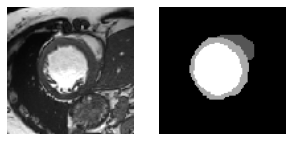

In [2]:
import os
import cv2 #import OpenCV

data_dir = './data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr3.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr3_mask.png'), cv2.IMREAD_UNCHANGED)


show_image_mask(image, mask, cmap='gray')
plt.pause(1)
# cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

# Implementation

When  building  our  network  we  chose  to  use  the  UNet  structure as described in (1), and adapt the code from (2) for our task.  We  initially  tried  to  implement SegNet, however this lead to less accurate results, with the highest score of 0.79.  UNet is structured so there is a convolution layer that maintains data’s dimensions, before then pooling the images into half their size,  and doubling the number of convolutions.  This is repeated for a desired number of steps, before the same process is then repeated but with image up scaling instead of pooling.


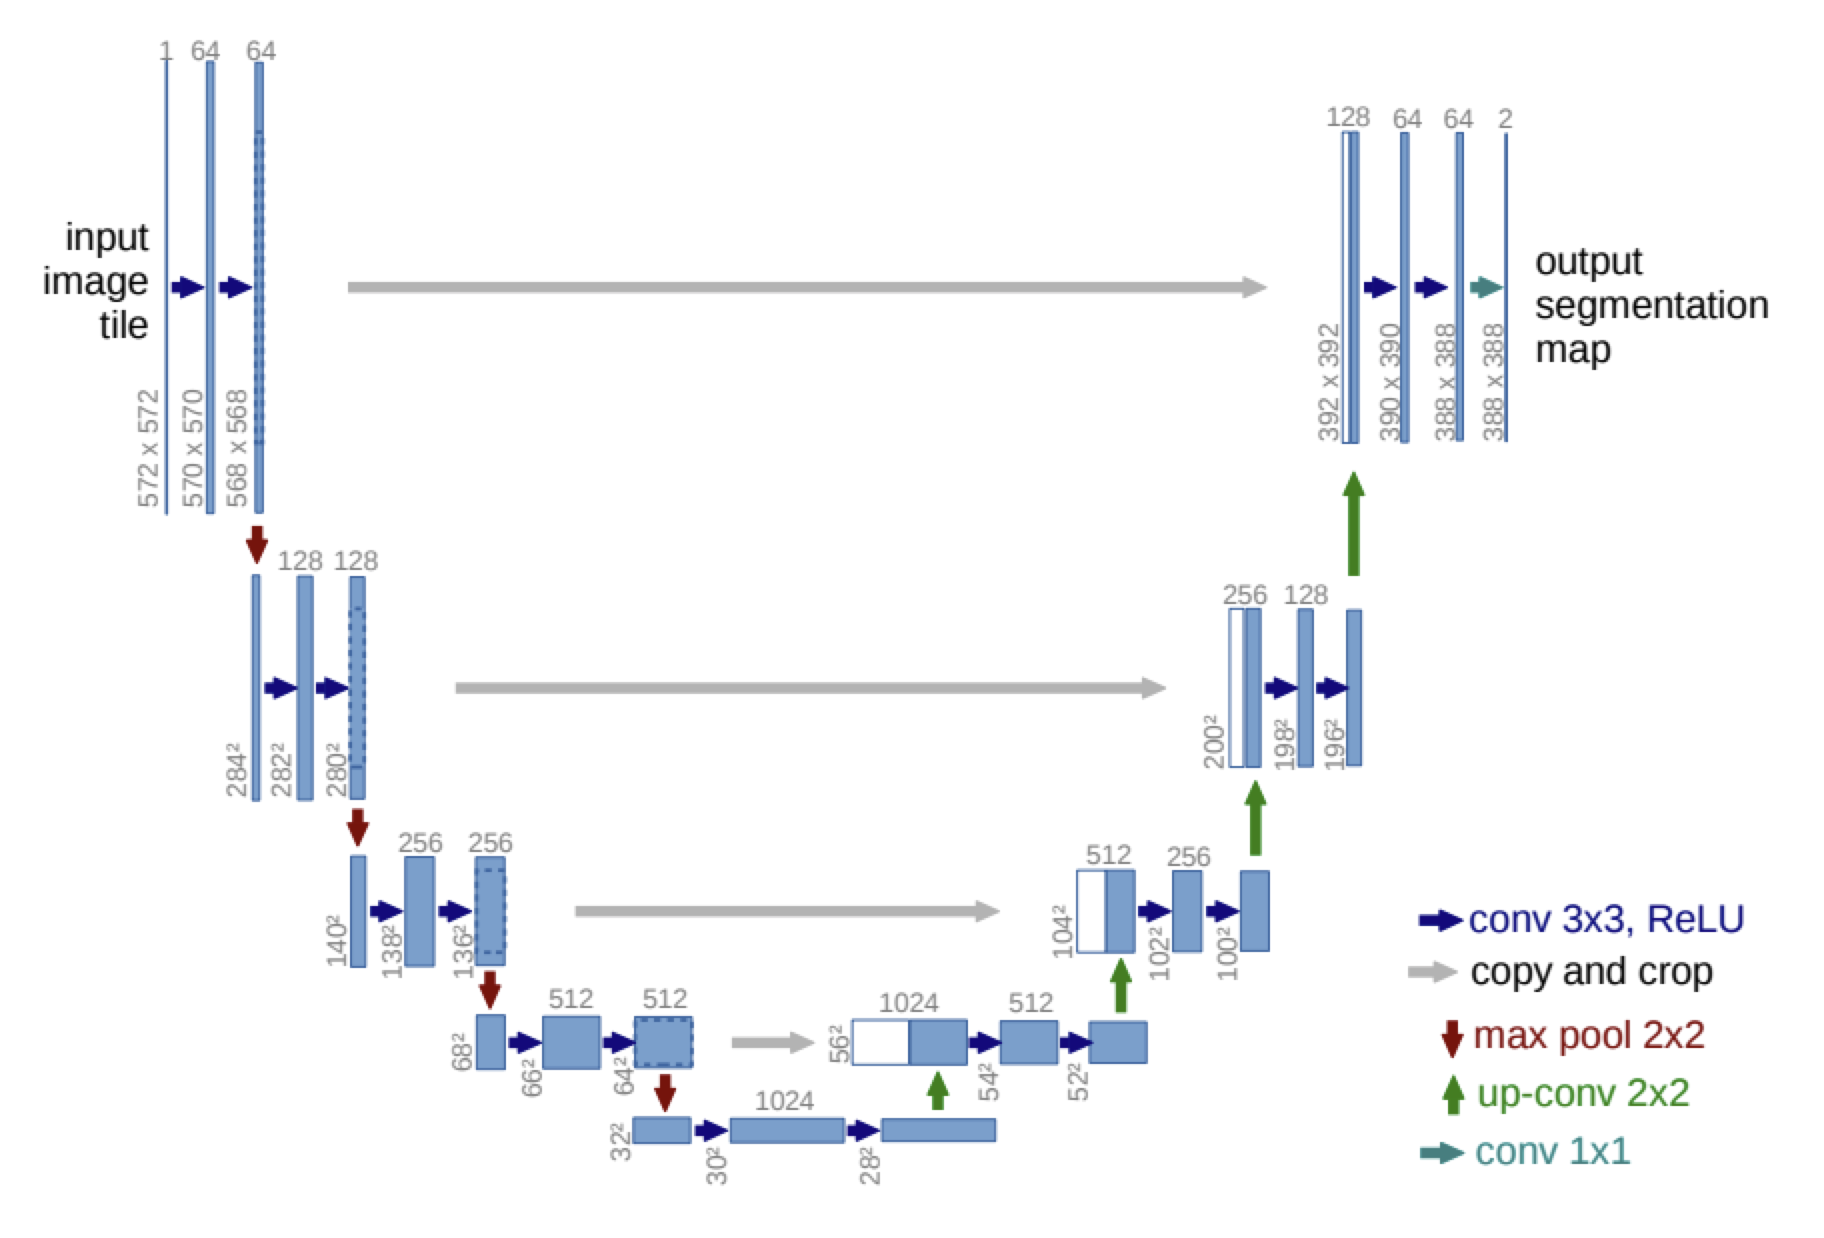

UNet performs semantic segmentation quickly this is vital since CPUs were used for much of our testing, rather than GPUs.  We did however have to modify the model structure in order to decrease training time,  allowing for sufficient testing.  The impact of altering the network structure on both time and performance of the network can be seen below in the experiments section.  Since our training set  contains  only  100  images,  the  fact  that  UNet  performs  well  on  a  very  small  training  set  was  a major advantage of this model.  Our choice was justified as in practice the model performed well on the dataset, in sufficiently low time. In  order  to  evaluate  the  models  performance  we  used  the  Dice  similarity  coefficient.   This  is  ameasure  of  how  well  the  predicted  mask  matches  the  ground  truth  mask.   Since  our  objective  was to maximise the Dice coefficient on the test set, we also used it to evaluate the performance on the validation set as a basis hyperparamter selection.  A larger dice score implies that more of each segment overlap.  Dice is calculated in the following way:

$$Dice(X,Y) = \frac{2|X\cap Y|}{|X|+|Y|}$$

The above equation applies to binary masks, since for our task there are 3 segments of interest, thedice score is calculated with respect to each of the 3 segments (i.e.treating any pixel with that classvalue as True and all others as False ) and then averaged.

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [3]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.img_files.sort() # sort the files with names
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
        # get the path of these images  

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float(), img_path 
            #also return the image name
            #change it from numpy to tesnor

    def __len__(self):
        return len(self.img_files)
        # how many train images

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.img_files.sort()

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), img_path

    def __len__(self):
        return len(self.img_files)

### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module): #Defines a double convolutional layer to be used in the network.

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(mid_channels), 
            nn.ReLU(inplace=True), 
            nn.Dropout(0.6),  
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module): #Defines the pooling layer class

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), # pooling the figure make the size smaller
            DoubleConv(in_channels, out_channels) # convlution 2 times
        ) 

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module): #Defines the upscaling layer class

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # up-pooling double the figure size
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2) #convolution the image 2 times, and make channels larger

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1) # copy and crop from the corresponding down layer

        return self.conv(x)


class OutConv(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) 
        # make the output channel become the specific channel

    def forward(self, x):
        return self.conv(x)

In [5]:
#UNet model
# shape 128
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNSEG(nn.Module):  # Define your model
    def __init__(self, n_channels, n_classes):
        super(CNNSEG, self).__init__()
        # fill in the constructor for your model here

        self.n_channels = n_channels # define input channel
        self.n_classes = n_classes   # define output channel
        
        # change the channel but keep the same figure size
        self.inc = DoubleConv(n_channels, 8) # 96*96*1 --> 96*96*8
        
        #decoder: in every function, convlove 2 times, change the channel and the figure size
        self.down1 = Down(8, 32) # 96*96*8 --> 48*48*32
        self.down2 = Down(32, 64) # 48*48*32 --> 24*24*64
        self.down3 = Down(64, 128) # 24*24*64 --> 12*12*128
        # keep the same channel, change the figure size
        self.down4 = Down(128, 128) # 12*12*128 --> 6*6*128
        
        self.up1 = Up(256, 64) # 6*6*128 --> 12*12*64
        self.up2 = Up(128, 32) # 12*12*64 --> 24*24*32
        self.up3 = Up(64, 8)   # 48*48*32 --> 96*96*8
        self.up4 = Up(16, 8)   #96*96*8 --> 96*96*8

        self.outc = OutConv(8, n_classes) # 96*96*8 --> 96*96*4

    def forward(self, x):
        x1 = self.inc(x)

        x2 = self.down1(x1)

        x3 = self.down2(x2)

        x4 = self.down3(x3)

        x5 = self.down4(x4)

        x = self.up1(x5, x4)

        x = self.up2(x, x3)

        x = self.up3(x, x2)

        x = self.up4(x, x1)

        logits = self.outc(x)

        return logits


model = CNNSEG(1, 4)  # We can now create a model using your defined segmentation model

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

# Loss Function (focal, dice loss)

In [9]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1e-5

 

    def forward(self, predict, target):
        N, C = predict.size()[:2]
        predict = predict.view(N, C, -1) 
        target = target.view(N, 1, -1) 

 

        predict = F.softmax(predict, dim=1) 
        
        target_onehot = torch.zeros(predict.size())  
        target_onehot.scatter_(1, target, 1)  

 

        intersection = torch.sum(predict * target_onehot, dim=2)  
        # the intersection of prediction and ground truth which is elment-wise multiply
        union = torch.sum(predict.pow(2), dim=2) + torch.sum(target_onehot, dim=2) 
        # the sum of prediction squared add the sum of target square
        
        dice_coef = (2 * intersection + self.smooth) / (union + self.smooth)  
        # 2|A and B| / |A| + |B|


        dice_coef = dice_coef * C  
        dice_loss = 1 - torch.mean(dice_coef)  

        return dice_loss
    
# Loss = DiceLoss()
# loss = Loss(y_predict, y_target)

In [8]:
#focal loss
from typing import Optional, Sequence
from torch import Tensor

class FocalLoss(nn.Module):
    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 0.,
                 ignore_index: int = -100):

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)
 
    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            y = y.view(-1)
 
        unignored_mask = y != self.ignore_index
        
        y = y[unignored_mask]
        if len(y) == 0:
            return 0.
        
        x = x[unignored_mask]

 
        log_p = F.log_softmax(x, dim=-1) #log(p)
        ce = self.nll_loss(log_p, y) 
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma #(1- p)^gamma
        loss = focal_term * ce
        loss = loss.mean()

        return loss


def focal_loss(alpha: Optional[Sequence] = None,
                gamma: float = 0.,
               ignore_index: int = -100) -> FocalLoss:

 
    fl = FocalLoss(
        alpha=alpha,
        gamma=gamma,
        reduction=reduction,
        ignore_index=ignore_index)
    
    return fl

# Loss = FocalLoss()

# Setting of learning rate, optimizer and loss function

In [10]:
learning_rate = 0.001

# Loss = nn.CrossEntropyLoss()
# Loss = DiceLoss()
Loss = FocalLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate,  weight_decay=1e-8, momentum=0.9)
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.005)

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [11]:
from torch.utils.data import DataLoader
import time

data_path = './data/train'


num_workers = 4
batch_size = 4 #Sets the batch size
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
num_epochs = 101 #Sets the number of epochs
# Fetch images and labels. 
record = [1, 5, 10, 20, 40, 60, 80, 100] #Epoch values for the model state to be saved at
start = time.time() #Sets the time the training started
for epoch in range(num_epochs):
    model.train()
    for iteration, sample in enumerate(training_data_loader):
        
        img, mask, name = sample
        img1 = img.unsqueeze(1)

        # Write your FORWARD below
        # Note: Input image to your model and ouput the predicted mask and Your predicted mask should have 4 channels
    
        y_predict = model.forward(img1)
        mask = mask.type(torch.long)
        loss = Loss(y_predict, mask)


    
        # Then write your BACKWARD & OPTIMIZE below
        # Note: Compute Loss and Optimize
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
    
       
        
    if epoch in record:
        finish = time.time() #records the time training finished for the epoch
        train_time = finish - start 
        print(train_time) #Prints the time it has taken to train the model to the current epoch
        torch.save(model.state_dict(), './data/unet_{}.pt'.format(epoch)) #Saves the state of the model 

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

# Generate test set's predict figures

In [17]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
from torchvision.utils import save_image
import numpy as np
from torch.autograd import Variable
from torch.utils.data import DataLoader
path = './data/unet_5.pt'

test_path = './data/test' #Set the path to the location of the test data
num_workers = 4
batch_size = 2

test_set = TestDataset(test_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers, batch_size = batch_size, shuffle=False)
test_no= 121 #test_no set to 121 as the labels for the test data begin at this value.

model.load_state_dict(torch.load(path)) #Loads the model specified by the path
model.eval() #Sets the model to evaluation mode

for sample, name in test_data_loader:

    img = sample.unsqueeze(1)

    x = model.forward(img) #passes the test data through the model
    
    for i in range(batch_size):
        predict_mask = torch.argmax(x[i].squeeze(), dim=0).detach().numpy() #stores the predicted mask image
        cv2.imwrite('./data/test/mask/cmr{}_mask.png'.format(test_no), predict_mask) #saves the pedicted mask image
        test_no +=1

# Generate validation set's predict figures

In [27]:
# val
# import os

mask2_path = "./data/val/mask2"
folder = os.path.exists(mask2_path)
if not folder:
    os.makedirs(mask2_path)
    

val_path = './data/val' #Sets the path to where the validation set is located

num_workers = 4
batch_size = 2

val_set = TrainDataset(val_path)
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

picture_no= 101

model.load_state_dict(torch.load(path)) #Loads the model specified by the path
model.eval() #Sets the model to evaluation mode
for iteration, sample in enumerate(val_data_loader):
    
    img, mask, name = sample
    img2 = img.unsqueeze(1)

    x = model.forward(img2) #passes the validation data through the model 
    
    
    for i in range(batch_size):
        predict_mask = torch.argmax(x[i].squeeze(), dim=0).detach().numpy() #stores the predicted mask image
        cv2.imwrite('./data/val/mask2/cmr{}_mask.png'.format(picture_no), predict_mask) #saves the pedicted mask image
        picture_no +=1
#Note that the mask2 folder in val_path location may need to be created if it does not already exist.
    

# Experiments

To carry out the experiments we first divided the data into a training set of 100 images, a validation set  of  20  images,  and  a  test  set  of  80  images.   We  used  the  training  set  to  train  the  model,  and then used the validation set to fine-tune our hyper-parameters and network settings by comparing the performance of the model with the different settings on the validation set.  Once we had found the hyper-parameter with the best performance we used the test set to measure the performance.

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32) 
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice #returns the categorical dice score

# the average dice score of val set

In [ ]:
data_dir = './data/val'


true_mask = []
predict_mask = []

for i in range(101, 121):
    mask1 = cv2.imread(os.path.join(data_dir,'mask','cmr{}_mask.png'.format(i)), cv2.IMREAD_UNCHANGED)
    mask2 = cv2.imread(os.path.join(data_dir,'mask2','cmr{}_mask.png'.format(i)), cv2.IMREAD_UNCHANGED)
    true_mask.append(mask1)
    predict_mask.append(mask2)

sum_val = 0
for i in range(len(true_mask)):

    summary = 0
    labe_class = 1
    for j in range(3):
        x = categorical_dice(true_mask[i], predict_mask[i], labe_class)
        summary +=x
        labe_class +=1
    average = summary/3 #Calculates the average dice score for each of the 3 segments of interest
    sum_val +=average #Adds the dice score for the individual datapoint to the total score
print("average dice of val samples:")
print(sum_val/len(true_mask)) #Prints the average dice score over all validation samples

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)



    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        
        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)


        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

# generate CSV file for kaggle

In [ ]:
submission_converter("/Users/nolan/CW2/data/test/mask", "/Users/nolan/CW2/data/test/submission")

# Results

## Epochs
Epoch  is  one  of  the  most  basic  hyper-parameters  in  the  neural  network,  relating  directly  to  the training of the network, it is the number of times the training set is used to update the parameters of  the  model.   There  are  many  factors  which  influence  how  many  epochs  a  model  requires  until  it performs to a high standard, for example using different optimisers may require a larger number of epochs if they train the model slowly.  For this reason, we consistently recorded results for a subset of  epochs,  measuring  how  the  model  improves.   This  can  give  us  an  insight  into  how  the  different hyper-parameters affect the training time as well as what the optimum number of epochs will be for any given set of hyperparameters.  It should be considered that increasing the number of epochs leads to a significant increase in the training time of the model.  When the number of epochs is too small it can lead to the model not being sufficiently trained and if it is too large it can lead to overfitting. When we had chosen our final hyperparameters for the model, optimum performance was achieved at 120 epochs.


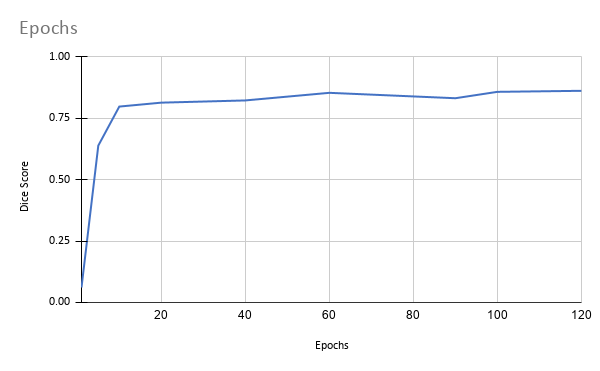

## Optimiser

We  tested  four  different  optimisers  which  were  Adam,  Standard  Gradient  Descent,  RMSProp  and AdaGrad.  We found that the best performing optimiser was Adam.  We studied how the different hyperparameters for the optimisers affected performance.  We used the UNet with 512 channels, 20e pochs, a batch size of 4 and the CrossEntropy loss function as our settings. First we tested how the Adam and RMSprop performed for different Learning rates, and we found that the best learning rate was 0.001 for both Adam and RMSProp, however Adam performed better than RMSprop.  For Adam we used the default values for $\beta_1$ = 0.9 and $\beta_2$ = 0.999.

| learning rate | Adam  | RMSProp |
|---------------|-------|---------|
| 0.1           | 0.802 | 0.785   |
| 0.01          | 0.827 | 0.823   |
| 0.001         | 0.862 | 0.851   |
| 0.0001        | 0.859 | 0.846   |


We then tested Standard Gradient Descent with momentum.  We test how accurate our network iswhen using the Standard Gradient Descent optimiser defined by the Pytorch library ”https://pytorch.org/docs/stable/optim.html”.We vary the momentum value to see if we can improve accuracy (dice score) with the following results:

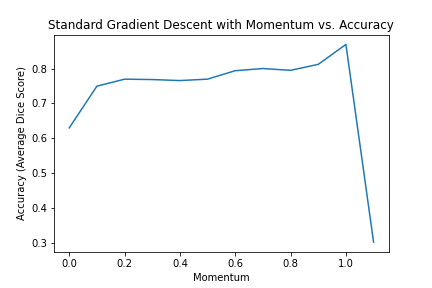

Here we see that our accuracy increases as we increase the momentum, until we set the momentum greater than 1, where the accuracy drops significantly.  We also found that AdaGrad was the worst performing optimiser with a maximum dice score of 0.82. These  results  mostly  follow  the  intuition  behind  each  optimiser.   From  AdaGad  we  introduce RMSProp because the learning rate for AdaGrad decays too aggressively, so we develop RMSProp toprevent the rapid growth of the denominator.  However, RMSProp carries out the same step along all features, which then leads to the use of Adam, which updates each feature of the model separately. The results show that Adam performed better than RMSProp, and RMSProp performed better than AdaGrad did.

## Batch Size of Training Set

Batch size is the number of training samples used for each update when using a variant of mini-batch gradient descent.  The following table illustrates how batch size effects the dice score achieved by the model.  The most effective batch size for this task is 4.  Larger and smaller batch sizes lead to loweraccuracy and larger training times.


| training set batch size | average dice of all val samples | training time(second) |
|-------------------------|---------------------------------|-----------------------|
| 2                       | 0.849                           | 95                    |
| 4                       | 0.853                           | 85.14                 |
| 5                       | 0.852                           | 86.27                 |
| 10                      | 0.845                           | 86.5                  |
| 20                      | 0.844                           | 89                    |
| 25                      | 0.846                           | 89                    |
| 50                      | 0.843                           | 96                    |


## Activation Function

The activation functions can have a significant effect on the performance of the network.  In the UNet architecture we applied there were 2 activation functions applied in every double convolution layer. By holding all other hyper parameters of the model constant we conducted experiments, evaluating how  each  of  the  following  activation  functions  performed:  ReLU,  Leaky  ReLU,  PReLU  and  Tanh.The activation function can influence both the final accuracy the model obtains and the number ofepochs a model takes to achieve sufficiently high performance.  See the graph below for the results: 

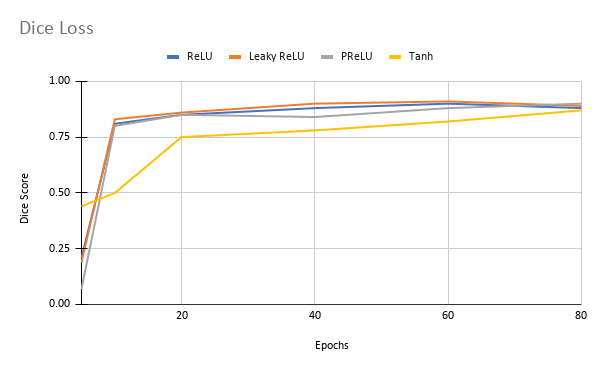

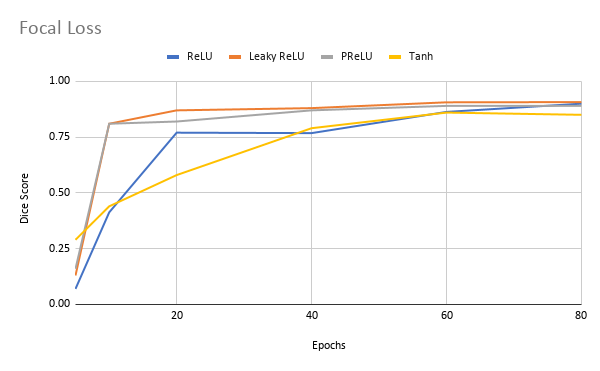

From the results we see that the best performing activation function was the Leaky ReLU activation function.  Leaky ReLU allows quicker updates whilst maintaining the simplicity of the ReLU activation function.  Tanh, despite being a more complex function, was the worst performing of the 3 models, it led to the slowest training of the model, and the lowest performance.  Whilst other activation functions may have gone on to achieve higher results, leaky ReLU gave exceptionally high results in a number of epochs which can viably be ran on a CPU. The training process, in terms of how long it took to perform 80 epochs remained similar regardless of which of the activation functions were used.

## Network Architecture 

### Shape

Here we experimented with the number of channels in the network.  We used the Adam Optimiser with a learning rate of 0.001 and the cross-entropy loss function.

64 channel means we make the figures from 96\*96\*1(width, height, channel) -> 96\*96\*4 -> 48\*48\*16 -> 24\*24\*32 -> 12\*12\*64 -> 6\*6\*64 then make the output become 96\*96\*4.

| epoch | average dice of all val samples | training time(second) |
|-------|---------------------------------|-----------------------|
| 1     | 0                               | 2                     |
| 5     | 0.06                            | 12                    |
| 10    | 0.154                           | 24                    |
| 20    | 0.494                           | 46                    |
| 40    | 0.527                           | 90                    |
| 60    | 0.838                           | 136                   |
| 80    | 0.849                           | 183                   |
| 100   | 0.849                           | 228                   |

128 channel means we make the figures from 96\*96\*1(width, height, channel) -> 96\*96\*8 -> 48\*48\*32 -> 24\*24\*64 -> 12\*12\*128 -> 6\*6\*128 then make the output become 96\*96\*4.

| epoch | average dice of all val samples | training time(second) |
|-------|---------------------------------|-----------------------|
|     1 | 0.475                           |                  4.27 |
|     5 | 0.775                           |                    21 |
|    10 | 0.835                           |                    41 |
|    20 | 0.859                           |                    82 |
|    40 | 0.841                           |                   166 |
|    60 | 0.868                           |                   257 |
|    80 | 0.868                           |                   338 |
|   100 | 0.866                           |                   420 |

256 channel means we make the figures from 96\*96\*1(width, height, channel) -> 96\*96\*32 -> 48\*48\*64 -> 24\*24\*128 -> 12\*12\*256 -> 6\*6\*256 then make the output become 96\*96\*4.

| epoch | average dice of all val samples | training time(second) |
|-------|---------------------------------|-----------------------|
|     1 | 0.173                           |                    17 |
|     5 | 0.789                           |                    89 |
|    10 | 0.852                           |                   177 |
|    20 | 0.861                           |                   357 |
|    40 | 0.873                           |                   712 |
|    60 | 0.877                           |                  1065 |
|    80 | 0.824                           |                  1418 |
|   100 | 0.861                           |                  1770 |

512 channel means we make the figures from 96\*96\*1(width, height, channel) -> 96\*96\*64 -> 48\*48\*128 -> 24\*24\*256 -> 12\*12\*512 -> 6\*6\*512 then make the output become 96*96*4.

| epoch | average dice of all val samples | training time(second) |
|-------|---------------------------------|-----------------------|
|     1 | 0.192                           |                    49 |
|     5 | 0.749                           |                   240 |
|    10 | 0.784                           |                   470 |
|    20 | 0.862                           |                   935 |
|    40 | 0.866                           |                  1878 |
|    60 | 0.879                           |                  2906 |
|    80 | 0.862                           |                  4514 |
|   100 | 0.866                           |                  5059 |

1024 channel means we make the figures from 96\*96\*1(width, height, channel) -> 96\*96\*64 -> 48\*48\*256 -> 24\*24\*512 -> 12\*12\*1024 -> 6\*6\*1024 then make the output become 96\*96\*4.

| epoch | average dice of all val samples | training time(second) |
|-------|---------------------------------|-----------------------|
|     1 | 0.073                           |                   141 |
|     5 | 0.744                           |                   715 |
|    10 | 0.817                           |                  1425 |
|    20 | 0.851                           |                  2803 |
|    40 | 0.865                           |                  5652 |
|    60 | 0.892                           |                  8543 |
|    80 | 0.888                           |                 11244 |
|   100 | 0.883                           |                 14356 |

As shown in the figure below, when the largest channel is set to 64, the performance of this model is the worst among all models.  Although the model with largest channel size of 1024 could get the highest  accuracy,  it  is  the  most  difficult  model  to  train  and  takes  several  times  longer  than  other models.  Thus the models with shape 128 or 512 are the most suitable model for this task.



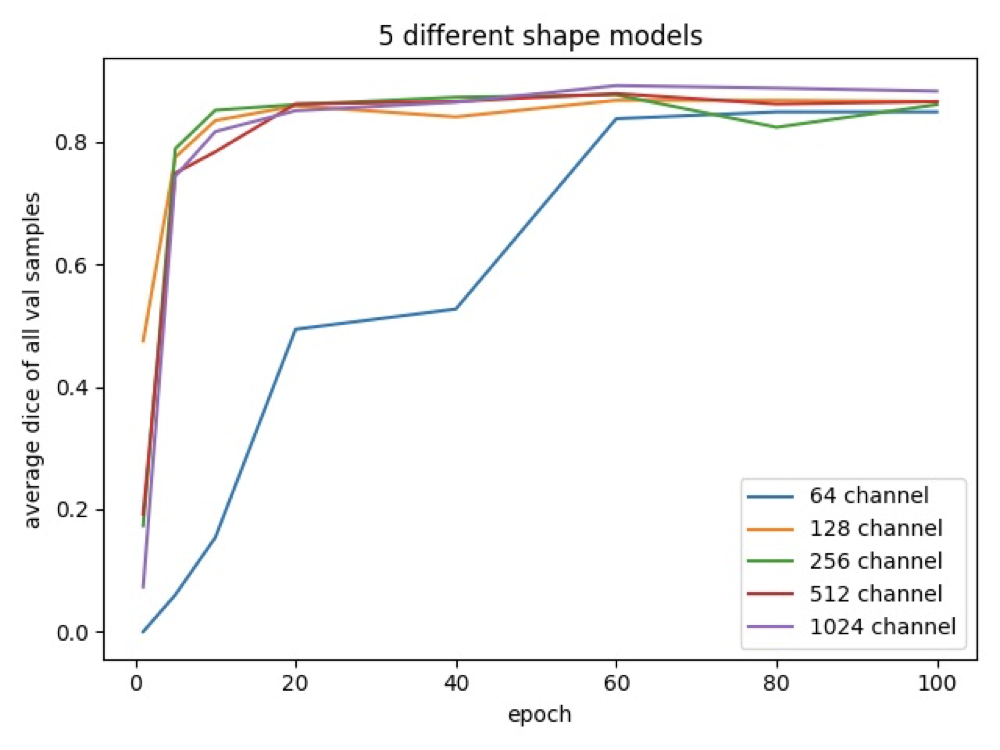

### Network Depth

Due to the way the UNet network is set up, another parameter we can investigate is how many layers deep  the  network  gets.   Since  UNet  reduces  the  size  of  the  image  until  a  certain  point,  before  upscaling back to the original image size, we can set how at what size the network stops down scaling
the image.  Since the original images were 96×96, we tested stopping the pooling when the outputs were 24×24,12×12,6×6 and 3×3.  We did not test any higher since the results for 24×24 were noticeably worse then the 12×12 results.

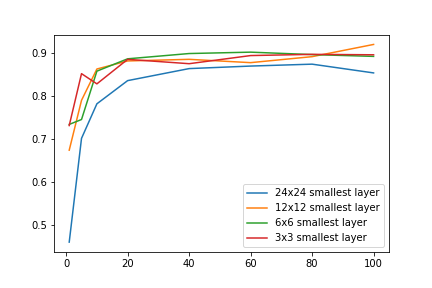

### Kernel Size

The next aspect of the network Architecture that we explored was the kernel size.  We tested using a UNet 128 architecture, Adam optimiser with learning rate 0.001, and Cross-entropy loss, stride 1.  We tried kernels of size 1x1(padding 0), 3x3(padding 1), 5x5(padding 2) as shown in the results below. We found that when the kernel was of size 1 it performed very poorly, with kernels of size 3 and 5 performing similarly but better than with kernel size 1.

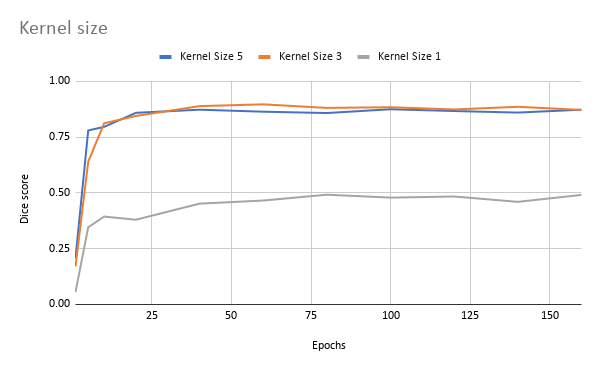

## Loss Function

We then tried changing the loss function.  We used the best optimiser we had found which was theAdam optimiser with a learning rate of 0.001.  We tried three different loss functions.  We first used cross-entropy which is included with PyTorch, and then we also tried the Focal loss and the soft Diceloss as found in (3) and (4).  We then tested each loss function with three different models, whichwere UNet-64, UNet-128, and UNet-512. We also found that all three loss functions take the same computing time when using the same model.  For example, UNet-64 took about 2 seconds per epoch for all three loss functions.  UNet-128 and UNet-512 took 5s and 50s per epoch respectively for all three loss functions.

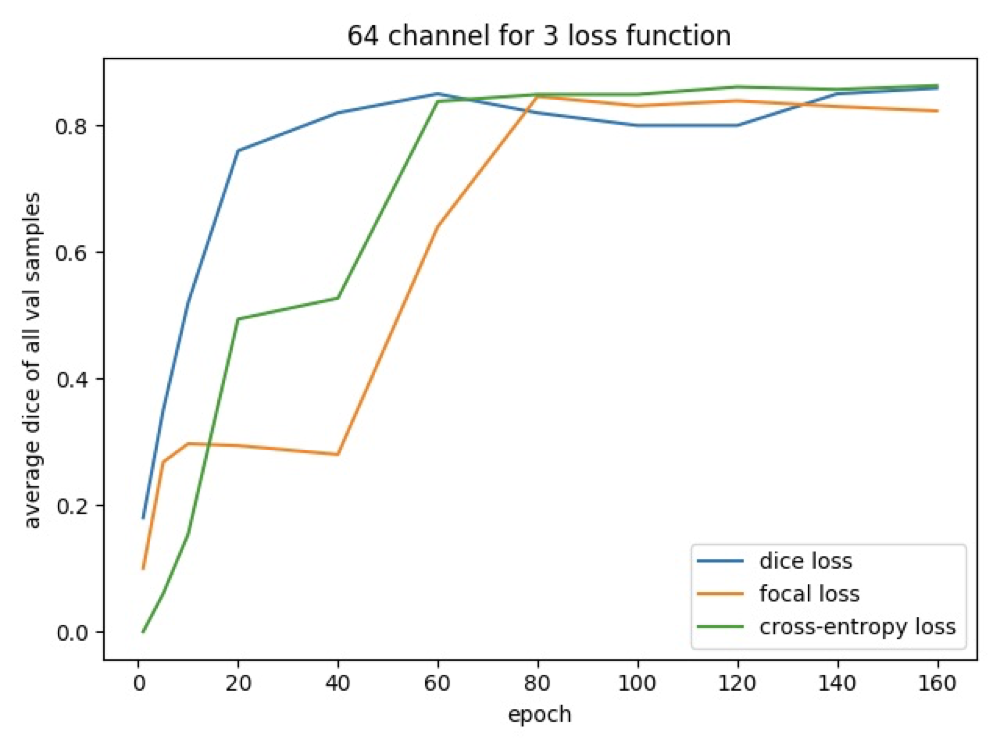

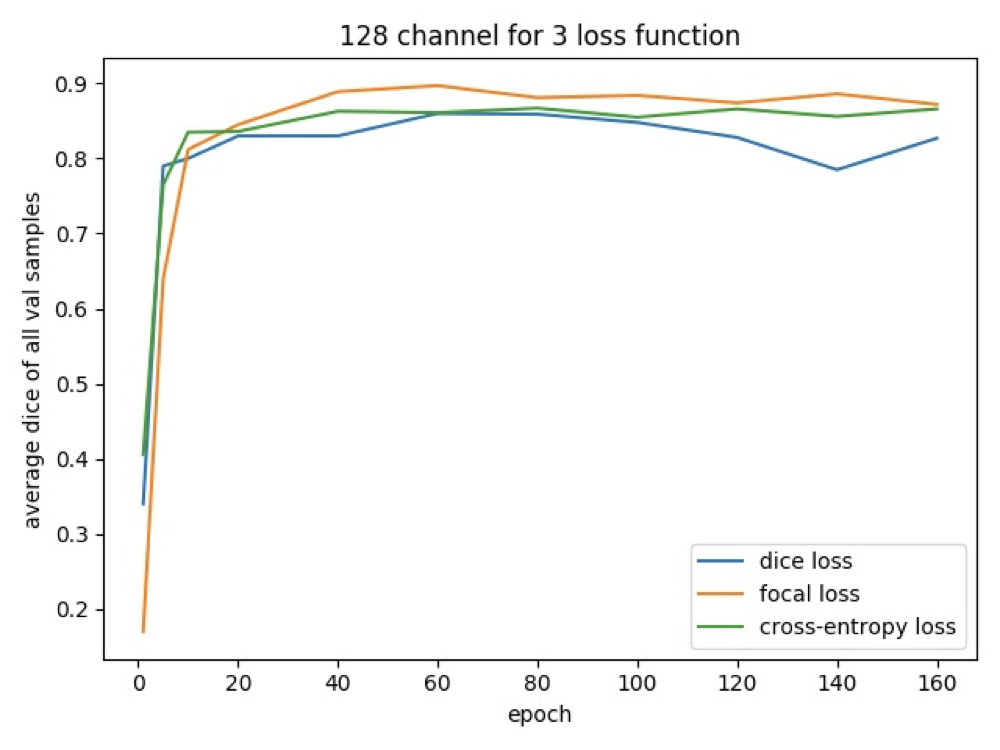

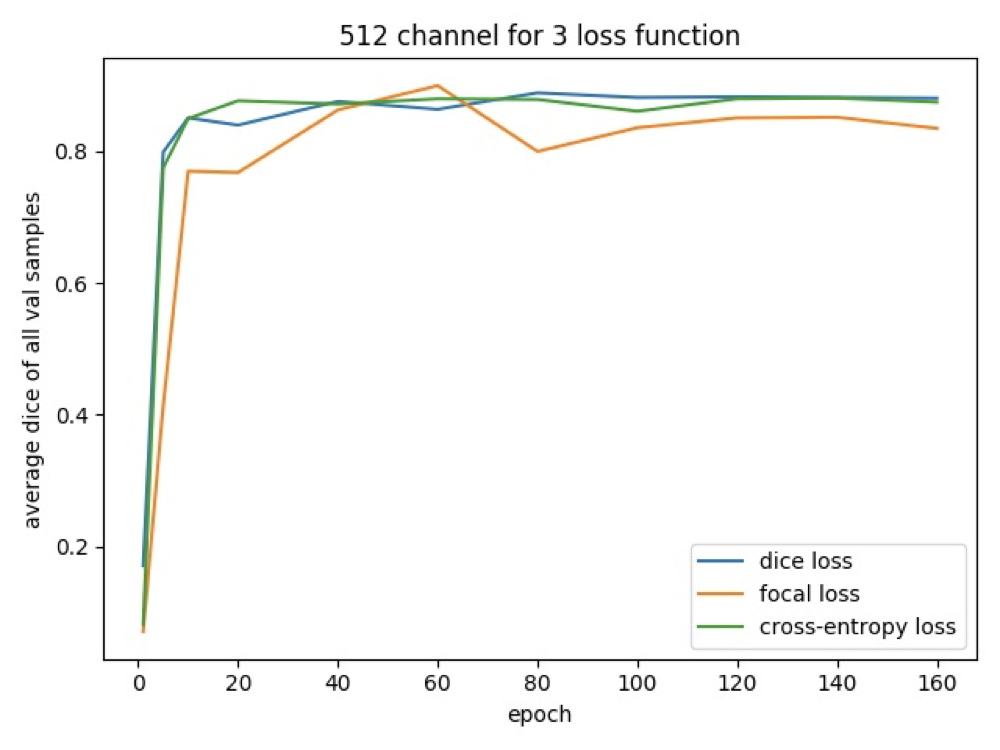

## Regularisation 

Due to the small number of training samples, we identified over-fitting as a potential problem for the network.  In order to combat this we conducted experiments on several regularisation techniques and implemented those which proved effective.

### Weight Decay

Weight Decay relies on adding a penalty to the loss function based on the size of the weights.  The larger  the  weights  in  the  model  the  larger  the  penalty,  reducing  the  capacity  of  the  model  to  overfit.  To evaluate the impact of weight decay we held all other hyper parameters in the model constant and only changed the weight decay parameter (influencing the size of the penalty incurred for large weights).  To evaluate these results we compared to the results of the model with weight decay set to 0.The  results  show  that  as  the  weight  decay  parameter  decreases  the  performance  of  the  model increases.  However for every weight decay value we tested, the network trained without weight decay outperforms it.  For this reason we decided not to include weight decay in our final model.  The poor performance of the networks which used weight decay indicates that large parameters are required to perform a task of this complexity.


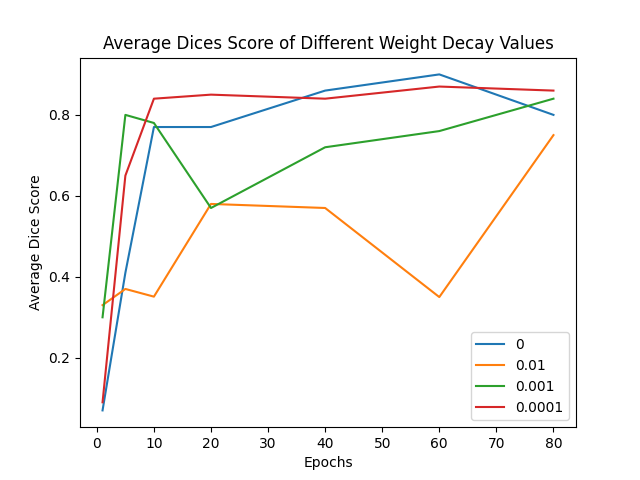

### Dropout

To try and overcome any issues of over fitting we have tried implementing dropout into the network. Overall the Dice score was relatively high for Dropout probabilities ranging from 0 to 0.9.  We only saw a drop in performance once the dropout probability was above 0.9.  This was expected to happen for ahigh enough probability.  Once we start dropping out too many neurons we lose to much information and the neural network starts to under perform.  The best dropout probability we obtained from the Validation set was for a probability of 0.6.  This achieved a dice score of 0.8807.


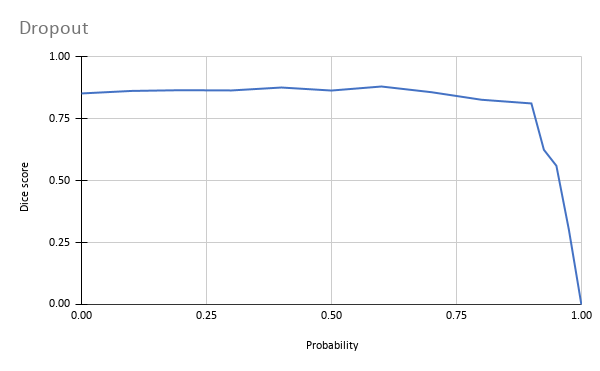

### Data Augmentation 

As we are working with a small training set, 100 CMR images and masks, this motivates us to try data augmentation.  Data augmentation can be applied as a pre-processing step in order to generate more CMR images and masks from the original images, increasing the size of our training set.  We hope that using a larger training set size will improve the accuracy of our network when running on unseen data. We are currently using OpenCV to handle our original data, OpenCV provides a number of functions which will allow us to perform data augmentation.  Note as we are using our network to perform an image segmentation task, the transformations that we apply to our CMR images we will also have to  apply  to  the  corresponding  masks  in  order  to  be  used  for  training  (note  this  doesn’t  apply  for Gaussian blur, which we shall discuss). We begin by implementing code that performs rotations and flips of our original CMR images and masks, we perform 5 transformations, namely:  three flips of the image - vertically, horizontally andhorizontally then vertically and two rotations - 90 degrees clockwise and anti-clockwise.  We learn how to use the cv2 Augmentation functions from (6). We then use those functions to create our augmented data set as shown below.



In [ ]:
import cv2
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from random import randint
import numpy as np


data_path = './data/train'
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, shuffle=False)

# CREATE LISTS TO STORE OUR AUGMENTED IMAGES AND MASKS
augmentedimg = []
augmentedmask = []

for iteration, sample in enumerate(training_data_loader):
        img, mask, name = sample
        
        # ADD THE ORIGINAL IMAGES AND MASKS TO THE NEW AUGMENTED LISTS
        augmentedimg.append(img.numpy().reshape(96,96))
        augmentedmask.append(mask.numpy().reshape(96,96))
        
        
        # FLIP IMAGES/MASKS VERTICALLY AND ADD TO LISTS
        img_flip_v = cv2.flip(img.numpy().reshape(96,96), 0)
        mask_flip_v = cv2.flip(mask.numpy().reshape(96,96), 0)
        augmentedimg.append(img_flip_v)
        augmentedmask.append(mask_flip_v)
        
        #FLIP IMAGES/MASKS HORIZONTALLY AND ADD TO LISTS
        img_flip_h = cv2.flip(img.numpy().reshape(96,96), 1)
        mask_flip_h = cv2.flip(mask.numpy().reshape(96,96), 1)
        augmentedimg.append(img_flip_h)
        augmentedmask.append(mask_flip_h)
        
        
        #FLIP IMAGES/MASKS HORIZONTALLY AND VERTICALLY AND ADD TO LISTS
        img_flip_hv = cv2.flip(img.numpy().reshape(96,96), -1)
        mask_flip_hv = cv2.flip(mask.numpy().reshape(96,96), -1)
        augmentedimg.append(img_flip_hv)
        augmentedmask.append(mask_flip_hv)
        
        #ROTATE IMAGES/MASKS 90 DEGREES CLOCKWISE AND ADD TO LISTS
        img_rotate_90_clockwise = cv2.rotate(img.numpy().reshape(96,96), cv2.ROTATE_90_CLOCKWISE)
        mask_rotate_90_clockwise = cv2.rotate(mask.numpy().reshape(96,96), cv2.ROTATE_90_CLOCKWISE)
        augmentedimg.append(img_rotate_90_clockwise)
        augmentedmask.append(mask_rotate_90_clockwise)
        
        #ROTATE IMAGES/MASKS 90 DEGREES COUNTERCLOCKWISE AND ADD TO LISTS     
        img_rotate_90_counterclockwise = cv2.rotate(img.numpy().reshape(96,96), cv2.ROTATE_90_COUNTERCLOCKWISE)
        mask_rotate_90_counterclockwise = cv2.rotate(mask.numpy().reshape(96,96), cv2.ROTATE_90_COUNTERCLOCKWISE)
        augmentedimg.append(img_rotate_90_counterclockwise)
        augmentedmask.append(mask_rotate_90_counterclockwise)

In [ ]:
# We use this to write the images and masks to premade folders
for i in range(len(augmentedimg)):
    cv2.imwrite('./data/train/augmentedBLUR300/image/cmr{}.png'.format(str(i+1)), augmentedimg[i])
    cv2.imwrite('./data/train/augmentedRotation/mask/cmr{}_mask.png'.format(str(i+1)), augmentedmask[i])

In [ ]:
# We check our images at random indexes
for i in [2,77,142,282,200,106,9]:
    plt.imshow(augmentedimg[i], cmap='gray')
    plt.show()

In [ ]:
# We check our masks at random indexes
for i in [2,77,142,282,200,106,9]:
    plt.imshow(augmentedmask[i], cmap='gray')
    plt.show()

In [ ]:
# We check the lengths of our lists to see how many images we have generated
print(len(augmentedimg))
print(len(augmentedmask))

We can see below an original training set image and the 5 newly generated training images from each of these transformations described:

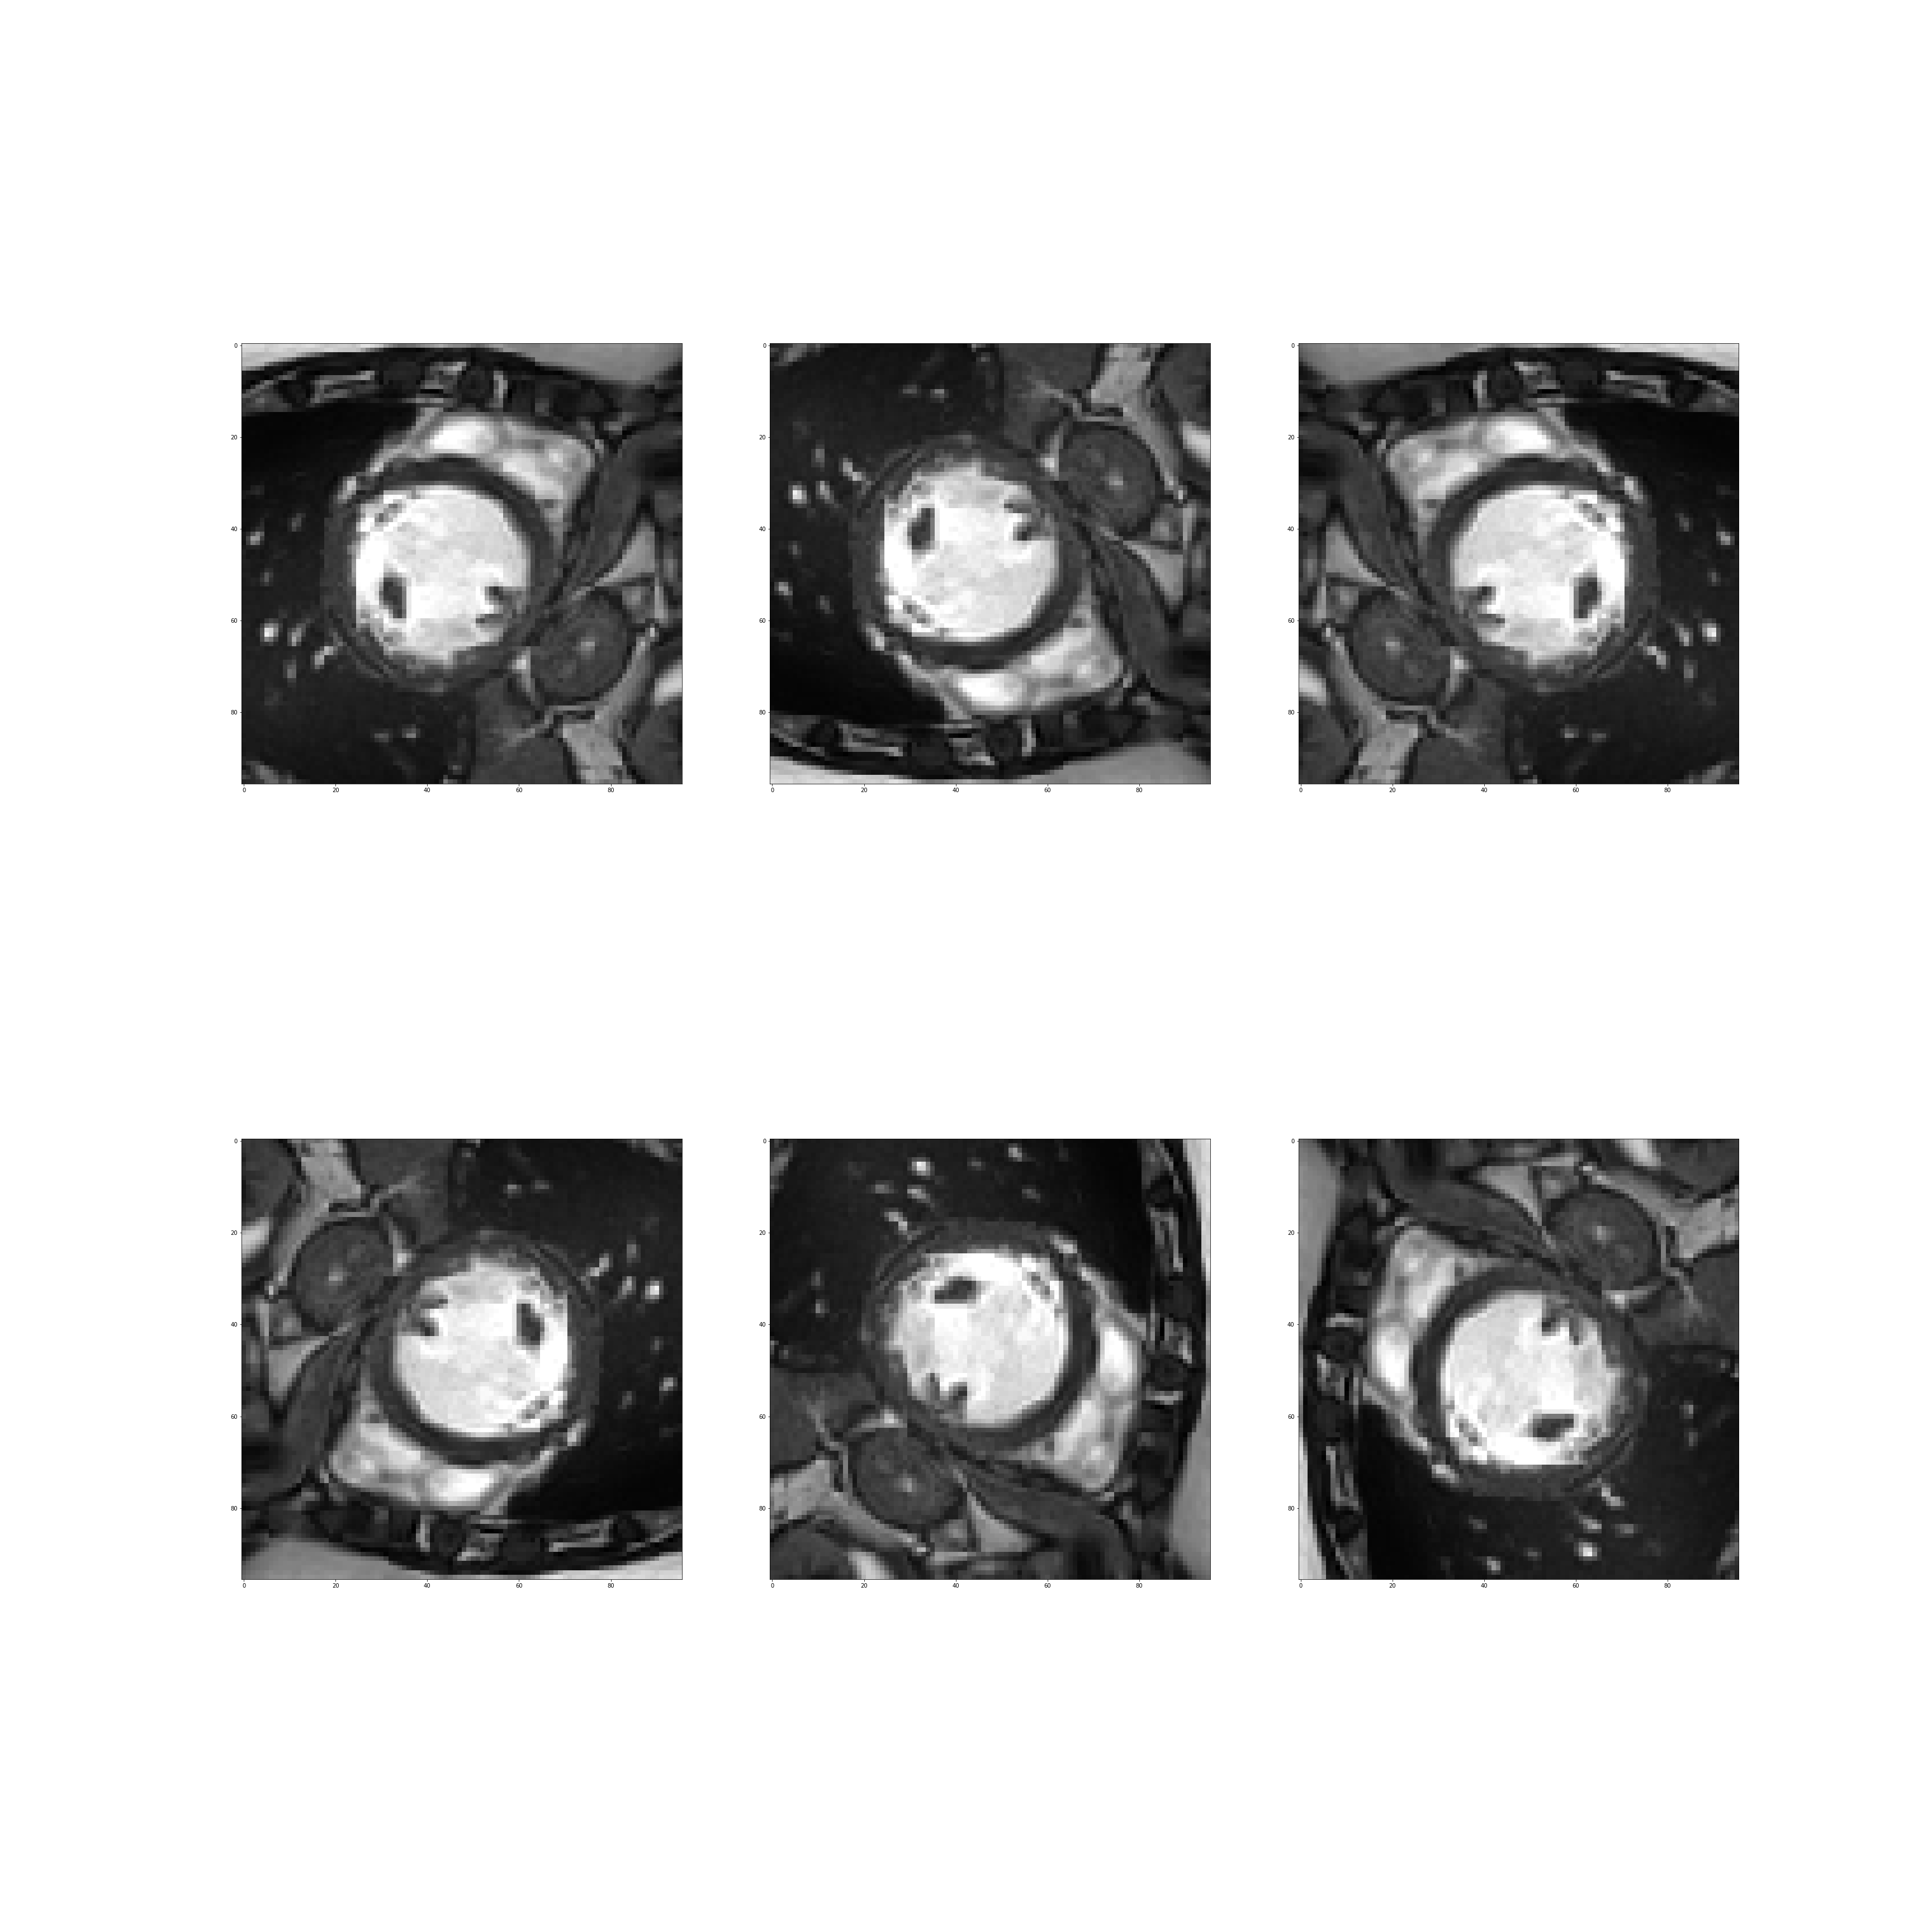

We perform these transformations for each image and mask in our training dataset resulting in a new training set containing 600 of both CMR and mask images, with 100 of these being the original training set.  We will test the accuracy when using this new training set. We  then  introduce  a  new  function  called  Gaussian  Blur  which  allows  us  to  remove  the  high-frequency components of our training data resulting in a blurred image as can be seen below.

We now add Gaussian noise creating a blur at even iterations, applying gaussian noise of intensity between integers 0-10
where 0 is a small amount of blur and 10 is greater. This results in 600 CMR images and masks where 100 are the original images and 500 are the augmented images with 250 of those having blurring applied to only the CMR images.

In [ ]:
data_path = './data/train'
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, shuffle=False)

# CREATE LISTS TO STORE OUR AUGMENTED IMAGES AND MASKS
augmentedimg = []
augmentedmask = []

# WE LOAD EACH SAMPLE FROM THE ORIGINAL TRAINING SET
for iteration, sample in enumerate(training_data_loader):
        img, mask, name = sample
        
        # ADD THE ORIGINAL IMAGES AND MASKS TO THE NEW AUGMENTED LISTS
        augmentedimg.append(img.numpy().reshape(96,96))
        augmentedmask.append(mask.numpy().reshape(96,96))
        
        
        # FLIP IMAGES/MASKS VERTICALLY AND ADD TO LISTS
        img_flip_v = cv2.flip(img.numpy().reshape(96,96), 0)
        mask_flip_v = cv2.flip(mask.numpy().reshape(96,96), 0)
        augmentedmask.append(mask_flip_v)
        
        #FLIP IMAGES/MASKS HORIZONTALLY AND ADD TO LISTS
        img_flip_h = cv2.flip(img.numpy().reshape(96,96), 1)
        mask_flip_h = cv2.flip(mask.numpy().reshape(96,96), 1)
        augmentedmask.append(mask_flip_h)
        
        
        #FLIP IMAGES/MASKS HORIZONTALLY AND VERTICALLY AND ADD TO LISTS
        img_flip_hv = cv2.flip(img.numpy().reshape(96,96), -1)
        mask_flip_hv = cv2.flip(mask.numpy().reshape(96,96), -1)
        augmentedmask.append(mask_flip_hv)
        
        #ROTATE IMAGES/MASKS 90 DEGREES CLOCKWISE AND ADD TO LISTS
        img_rotate_90_clockwise = cv2.rotate(img.numpy().reshape(96,96), cv2.ROTATE_90_CLOCKWISE)
        mask_rotate_90_clockwise = cv2.rotate(mask.numpy().reshape(96,96), cv2.ROTATE_90_CLOCKWISE)
        augmentedmask.append(mask_rotate_90_clockwise)
        
        #ROTATE IMAGES/MASKS 90 DEGREES COUNTERCLOCKWISE AND ADD TO LISTS     
        img_rotate_90_counterclockwise = cv2.rotate(img.numpy().reshape(96,96), cv2.ROTATE_90_COUNTERCLOCKWISE)
        mask_rotate_90_counterclockwise = cv2.rotate(mask.numpy().reshape(96,96), cv2.ROTATE_90_COUNTERCLOCKWISE)
        augmentedmask.append(mask_rotate_90_counterclockwise)
        
        
        
        # ADD GAUSSIAN NOISE (BLUR) OF RANDOM INTENSITY (0-10) TO HALF THE GENERATED IMAGES
        if iteration%2==0:
            augmentedimg.append(gaussian_blur(img_flip_v,randint(0,10)))
            augmentedimg.append(gaussian_blur(img_flip_h,randint(0,10)))
            augmentedimg.append(gaussian_blur(img_flip_hv,randint(0,10)))
            augmentedimg.append(gaussian_blur(img_rotate_90_clockwise,randint(0,10)))
            augmentedimg.append(gaussian_blur(img_rotate_90_counterclockwise,randint(0,10)))
        else:
            augmentedimg.append(img_flip_v)
            augmentedimg.append(img_flip_h)
            augmentedimg.append(img_flip_hv)
            augmentedimg.append(img_rotate_90_clockwise)
            augmentedimg.append(img_rotate_90_counterclockwise)

This code then produces the blurred image seen below from the first original image.

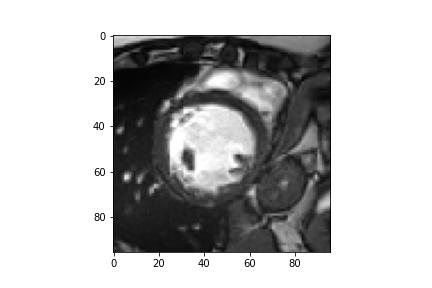

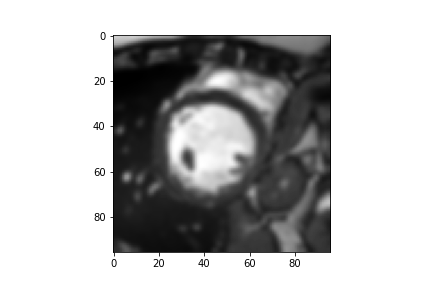

We apply this just to the CMR images and leave the mask images alone, as we want our network to associate the standard mask image to the blurry CMR image.  We hope that when training using this new augmented data we will again improve the network performance when running on unseen data.  We begin with the original 100 CMR and mask images and then flip and rotate the images inthe same way as before to generate 500 new CMR and mask images.  However, this time when ouriteration is an even number we will apply Gaussian blur which results in half of the newly produced images being blurred with varying intensity depending on a random integer generated between 0-10 (with  0  being  some  blur  and  10  more).   This  results  with  us  having  a  new  training  set  containing 600 CMR and mask images, 100 of these are the original provided, 500 have been generated through rotations and flips with 250 of those being blurred to varying degree.  We will see again if this improves our networks accuracy.

We test the effects of using this different data.  We decide to use the following parameters and network architecture:  UNet-256,  optimiser-Adam,  batch size=4,  learning rate=0.001,  cross entropy as our loss function and epochs=5.  We have chosen some of these namely the UNet-256 architectureand 5 epochs to reduce run time as when we increase the training set size it will drastically increase the training time needed.  We train the network on each kind of data 5 times and take an average to take into account the random initialisation that is present within the network.  We yield the following results:


| Data                          | Average training time(second) | Average dice score |
|-------------------------------|-------------------------------|--------------------|
|                      Original | 134.02                        |             0.5945 |
|           Rotated and flipped | 757.11                        |             0.7387 |
| Rotated and flipped with blur | 761.54                        |              0.205 |

Here we see that for the original 100 images it is around 6x faster than for the 600 images, which is as expected.  We see that when we train using the rotated and flipped data our accuracy increases,however when we apply blur to some of the images the accuracy decreases to worse than when training using just the original set.  We suspect this is due to not applying an optimal amount of blurring tothe images as we are using a integer from a random range (0-10) to specify the amount.  Although it could be due to not using enough epochs to allow the network to converge, we have chosen a small amount to decrease the run time however it means large fluctuations in the accuracy as a result of the randomness present in the network.  However, that is why we have taken an average after training the network on each data 5 times to try and reduce this affect.  We use these results with caution as we are aware more testing is required before we can say for sure how exactly each data affects the accuracy.

# Conclusion

For  our  best  results,  we  found  that  the  best  structure  of  the  network  was  to  have  a  kernal  size  of 3, with a padding of 1.  We also used Leaky ReLU after each convolution aswell as probability dropout of 0.6.  This followed the UNet architecture for three poolings of the data, so it went as deep as reducing the images down to 1212 images.  Then with a learning rate of 0.001, a loss function of FocalLoss, the optimiser of Adam and after 90 epochs, we achieved a model with 0.9199 Dice Score on the validation set. Amongst the many factors we explored, some had a bigger impact on the performance than others. We obtained the biggest changes in performance when changing the structure of the the neural network,such as the number of output channels, the network depth or the kernel size.  We saw this clearly when we first tried using SegNet and could only achieve a best performance of 0.79.  Another aspect that greatly improved our performance was augmenting the data, hence showing that the size of the initial training set was not good enough.  Perhaps the next area we could explore if we had more computation power, would be to expand the training set further by considering different ways of augmenting the data. 

## Bibliography

1. Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

2. UNet Code, URL: https://github.com/milesial/Pytorch-UNet

3. Focal Loss, URL:  https://github.com/AdeelH/pytorch-multi-class-focal-loss

4. Dice Loss, URL:  https://github.com/shuaizzZ/Dice-Loss-PyTorch

5. Data Augmentation, URL: https://www.kaggle.com/parulpandey/overview-of-popular-image-augmentation-packages